In [1]:
%cd ~/mechanistic-unlearning
%load_ext autoreload
%autoreload 2
import functools
import os
import gc
import json
# from tkinter import font
import sys

from dataset.custom_dataset import PairedInstructionDataset
import torch

from transformer_lens import HookedTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import numpy as np
from tqdm.auto import tqdm
from datasets import load_dataset
import einops
from transformer_lens import ActivationCache
import time
import pandas as pd
import matplotlib.pyplot as plt

# project_root = os.path.abspath(os.path.dirname(__file__))
project_root = "/data/phillip_guo/mechanistic-unlearning"

# Add the project root and its subdirectories to the Python path
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'masks_learning'))
sys.path.insert(0, os.path.join(project_root, 'localizations'))
sys.path.insert(0, os.path.join(project_root, 'tasks'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/opt/conda/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/mechanistic-unlearning


In [2]:
# model_name = "google/gemma-2-9b"
# model_type = "gemma2_9b"
# model_name = "google/gemma-2-9b"
# model_type = "gemma2_9b"
model_name = "meta-llama/Meta-Llama-3-8B"
model_type = "llama3_8b"
model = HookedTransformer.from_pretrained(
    model_name,
    device='cuda',
    default_padding_side="left",
    # default_padding_side="right",
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)
tokenizer = model.tokenizer

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Meta-Llama-3-8B into HookedTransformer


## Develop CounterFact Dataset

In [3]:
import pandas as pd
from datasets import Dataset, DatasetDict

orig_counterfact = load_dataset("azhx/counterfact")
orig_counterfact_df = pd.concat([orig_counterfact["train"].to_pandas(), orig_counterfact["test"].to_pandas()])
def get_prompt(row):
    return row["requested_rewrite"]["prompt"].replace("{}", row["requested_rewrite"]["subject"])
orig_counterfact_df["prompt"] = orig_counterfact_df.apply(get_prompt, axis=1)

dataset_dict = {}
for model_type in ["gemma2_9b", "gemma_7b"]:
    counterfact_df = load_dataset("PhillipGuo/counterfact-with-gemma-probs", split=model_type).to_pandas()
    # add paraphrase, rewrite, and neighborhood
    # counterfact_df = counterfact_df.merge(orig_counterfact_df.drop_duplicates(subset=["prompt"]), on="prompt", how="left")
    counterfact_df["prompt_id"] = counterfact_df.index
    dataset_dict[model_type] = Dataset.from_pandas(counterfact_df)

# Create a DatasetDict with two splits
dataset_dict = DatasetDict(dataset_dict)

dataset_dict.push_to_hub("PhillipGuo/counterfact-with-gemma-probs")


In [4]:
import pandas as pd

# counterfact_df = load_dataset("NeelNanda/counterfact-tracing", split="train").to_pandas()
# counterfact_df["prompt"] + counterfact_df["target_true"]
counterfact_df = load_dataset("PhillipGuo/counterfact-with-gemma-probs", split=model_type).to_pandas()
counterfact_df = counterfact_df[counterfact_df["prob_of_correct_answer"] >= 0.5]


In [7]:
# def get_token_sequence_pos(prompt_list, token_strs, batch_size=64):
    
#     last_substring_positions = []
#     for i in tqdm(range(0, len(prompt_list), batch_size)):
#         tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
        
#         tokenized_substrings = tokenizer(token_strs[i:i+batch_size]).input_ids
#         for j in range(len(tokenized_substrings)):
#             if tokenized_substrings[j][0] == tokenizer.bos_token_id:
#                 substring = tokenized_substrings[j][1:]
#             else:
#                 substring = tokenized_substrings[j]
#             substring = torch.tensor(substring)
#             prompt = tokenized_prompts.input_ids[j]
#             # print(prompt, substring)

#             # Find the last occurrence of the substring
#             for k in range(len(prompt) - len(substring), -1, -1):
#                 if torch.all(prompt[k:k+len(substring)] == substring):
#                     last_substring_positions.append(k - len(prompt))
#                     break
#             else:
#                 # If substring not found, append 1
#                 last_substring_positions.append(1)
#     return last_substring_positions

# substring_positions = get_token_sequence_pos((counterfact_df["prompt"] + counterfact_df["target_true"]).tolist(), counterfact_df["target_true"].tolist())
def get_token_sequence_pos(tokenizer, prompt_list, token_strs, batch_size=64, token_side="left"):
    
    substring_start_positions = []
    substring_end_positions = []
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
        
        tokenized_substrings = tokenizer(token_strs[i:i+batch_size]).input_ids
        for j in range(len(tokenized_substrings)):
            if tokenized_substrings[j][0] == tokenizer.bos_token_id:
                substring = tokenized_substrings[j][1:]
            else:
                substring = tokenized_substrings[j]
            substring = torch.tensor(substring)
            prompt = tokenized_prompts.input_ids[j]
            # print(prompt, substring)

            # Find the last occurrence of the substring
            for k in range(len(prompt) - len(substring), -1, -1):
                if torch.all(prompt[k:k+len(substring)] == substring):
                    if token_side == "left":
                        substring_start_positions.append(k - len(prompt))
                        substring_end_positions.append(k + len(substring) - len(prompt))
                    else:
                        substring_start_positions.append(k)
                        substring_end_positions.append(k + len(substring))
                    break
            else:
                substring_start_positions.append(1)
                substring_end_positions.append(1)
    return substring_start_positions, substring_end_positions
substring_start_positions, substring_end_positions = get_token_sequence_pos(tokenizer, (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist(), counterfact_df["target_true"].tolist(), token_side="right")

  0%|          | 0/343 [00:00<?, ?it/s]

In [8]:
from tasks.facts.CounterFactTask import CounterFactTask_Paraphrase, CounterFactTask_Neighborhood
paraphrase_task = CounterFactTask_Paraphrase(tokenizer=tokenizer, device=device, batch_size=16)
print(paraphrase_task.get_test_accuracy(model, use_test_data=True, n_iters=10))
neighborhood_task = CounterFactTask_Neighborhood(tokenizer=tokenizer, device=device, batch_size=16)
print(neighborhood_task.get_test_accuracy(model, use_test_data=True, n_iters=10))

AssertionError: Tokenizer should be right-padded for this task

In [9]:
for i, prompt in enumerate((counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()):
    if substring_start_positions[i] - substring_end_positions[i] != -1:
        print(substring_start_positions[i] - substring_end_positions[i])
        print(tokenizer.decode(tokenizer(prompt).input_ids[substring_start_positions[i]:substring_end_positions[i]]))

-2

-2

-2

-2

-2

-2

-2

-2
 Caucasus
-2
ender
-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2
er
-2
 mathematician
-2

-2

-2

-2

-2

-2

-2

-2

-2
ender
-2

-2

-2

-2

-2

-2

-2

-2

-2

-2
bi
-2

-2

-2

-2

-2

-2

-2

-2

-2

-2
ender
-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2
ender
-2

-2
ender
-2
ender
-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2
ender
-2

-2

-2

-2

-2

-2

-2
 goaltender
-2

-2

-2

-2
 Hiroshima
-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2
 goaltender
-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2
cca
-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2
ender
-2

-2

-2

-2

-2

-2
 goaltender
-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2
ender
-2

-2

-2
 goaltender
-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2

-2


  0%|          | 0/343 [00:00<?, ?it/s]

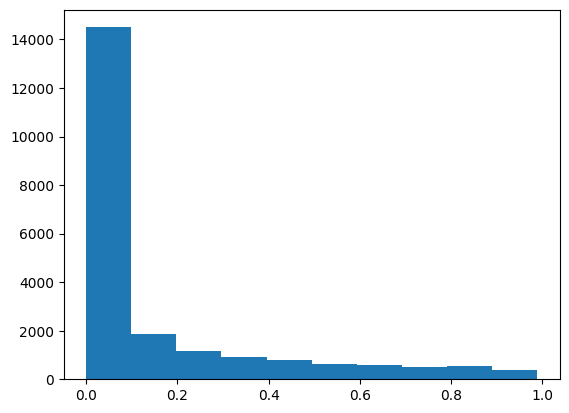

In [10]:
# model process full prompt
batch_size = 64
prompt_list = (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()
tokenized_substrings = tokenizer(counterfact_df["target_true"].tolist()).input_ids

correct_probs = []
for i in tqdm(range(0, len(prompt_list), batch_size)):
    tokenized = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
    prompt_toks = tokenized.input_ids
    attn_mask = tokenized.attention_mask
    current_substring_positions = substring_start_positions[i:i+batch_size]

    with torch.set_grad_enabled(False):
        output = model(prompt_toks.cuda(), attention_mask=attn_mask.cuda())
    
    for j in range(len(current_substring_positions)):
        # check [pos-1: -1]
        answer_preds = output[j, current_substring_positions[j]-1: -1]

        if tokenized_substrings[i+j][0] == tokenizer.bos_token_id:
            label = tokenized_substrings[i+j][1:]
        else:
            label = tokenized_substrings[i+j]
        label = torch.tensor(label)
        
        # get probability of correct answer across all label tokens (answer_preds is answer_len x vocab, label is shape (answer_len,))
        probs = torch.nn.functional.softmax(answer_preds, dim=-1)
        correct_prob = probs[torch.arange(len(label)), label]
        # multiply across answer_len
        correct_probs.append(torch.prod(correct_prob).item())
    # print(torch.tensor(correct_probs).mean())
import matplotlib.pyplot as plt
plt.hist(correct_probs)
plt.show() 

## Filter for correct predictions

  0%|          | 0/343 [00:00<?, ?it/s]

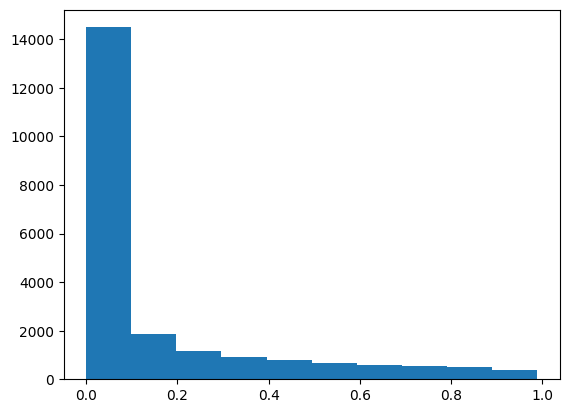

In [11]:
counterfact_df = load_dataset("PhillipGuo/counterfact-with-gemma-probs", split="gemma_7b").to_pandas()
prompt_list = counterfact_df["prompt"].tolist()
answer_list = counterfact_df["target_true"].tolist()
first_token_list = []
first_token_probs_list = []
batch_size = 64
for i in tqdm(range(0, len(prompt_list), batch_size)):    
    tokenized = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
    prompt_toks = tokenized.input_ids
    attn_mask = tokenized.attention_mask
    with torch.set_grad_enabled(False):
        output = model(prompt_toks.cuda(), attention_mask=attn_mask.cuda())

    first_tokens = tokenizer(answer_list[i:i+batch_size]).input_ids
    if first_tokens[0][0] == tokenizer.bos_token_id:
        first_tokens = [x[1] for x in first_tokens]
    else:
        first_tokens = [x[0] for x in first_tokens]
    first_tokens = torch.tensor(first_tokens)
    first_token_list.append(first_tokens)
    output = output[:, -1]
    
    probs = torch.nn.functional.softmax(output, dim=-1)
    batch_correct_probs = probs[torch.arange(len(first_tokens)), first_tokens]

    first_token_probs_list.append(batch_correct_probs)

first_token_probs = torch.cat(first_token_probs_list, dim=0).cpu().float().numpy()
first_token_list = torch.cat(first_token_list, dim=0)
plt.hist(first_token_probs)
plt.show()

In [6]:
# model process full prompt
counterfact_df = load_dataset("PhillipGuo/counterfact-with-gemma-probs", split="gemma_7b").to_pandas()
batch_size = 64
prompt_list = (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()
tokenized_substrings = tokenizer(counterfact_df["target_true"].tolist()).input_ids

first_token_probs_list = []
first_token_list = []
for i in tqdm(range(0, len(prompt_list), batch_size)):
    tokenized = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
    prompt_toks = tokenized.input_ids
    attn_mask = tokenized.attention_mask
    current_substring_positions = substring_start_positions[i:i+batch_size]

    with torch.set_grad_enabled(False):
        output = model(prompt_toks.cuda(), attention_mask=attn_mask.cuda())
    
    for j in range(len(current_substring_positions)):
        # check [pos-1: -1]
        answer_preds = output[j, current_substring_positions[j]-1: current_substring_positions[j]]

        if tokenized_substrings[i+j][0] == tokenizer.bos_token_id:
            label = tokenized_substrings[i+j][1:2]
        else:
            label = tokenized_substrings[i+j][0:1]
        label = torch.tensor(label)
        
        # get probability of correct answer across all label tokens (answer_preds is answer_len x vocab, label is shape (answer_len,))
        probs = torch.nn.functional.softmax(answer_preds, dim=-1)
        correct_prob = probs[torch.arange(len(label)), label]
        first_token_probs_list.append(correct_prob.item())
        first_token_list.append(label.item())
    # print(torch.tensor(correct_probs).mean())
import matplotlib.pyplot as plt
first_token_probs = torch.tensor(first_token_probs_list)
first_token_list = torch.tensor(first_token_list)
plt.hist(first_token_probs)
plt.show()

  0%|          | 0/343 [00:00<?, ?it/s]

NameError: name 'substring_start_positions' is not defined

In [18]:
# add "correct_prob" and "correct_first_token_prob" to the df
counterfact_df["prob_of_correct_answer"] = correct_probs
counterfact_df["prob_of_correct_first_token"] = first_token_probs
counterfact_df["first_token"] = first_token_list
display(counterfact_df)
os.makedirs(f"experiments/{model_type}_manual", exist_ok=True)
counterfact_df.to_parquet(f"experiments/{model_type}_manual/counterfact_df.parquet")

,relation,relation_prefix,relation_suffix,prompt,relation_id,target_false_id,target_true_id,target_true,target_false,subject,...,prob_of_correct_first_token,first_token,case_id,pararel_idx,requested_rewrite,paraphrase_prompts,neighborhood_prompts,attribute_prompts,generation_prompts,prompt_id
0,The mother tongue of {} is,The mother tongue of,is,The mother tongue of Danielle Darrieux is,P103,Q1860,Q150,French,English,Danielle Darrieux,...,7.031250e-01,8753,0,2796,"{'prompt': 'The mother tongue of {} is', 'rela...",[Shayna does this and Yossel goes still and di...,"[The mother tongue of Léon Blum is, The native...","[J. R. R. Tolkien is a native speaker of, The ...","[Danielle Darrieux's mother tongue is, Where D...",0
1,The official religion of {} is,The official religion of,is,The official religion of Edwin of Northumbria is,P140,Q432,Q5043,Christianity,Islam,Edwin of Northumbria,...,1.259766e-01,32186,1,19501,"{'prompt': 'The official religion of {} is', '...",[The school chiefly served tribal girls of Dan...,"[The official religion of Charles Aznavour is,...",[Dave Chappelle is affiliated with the religio...,[Edwin of Northumbria's religious values stron...,1
2,"{}, the",,"{}, the","Toko Yasuda, the",P1303,Q5994,Q6607,guitar,piano,Toko Yasuda,...,2.574921e-05,17418,2,13704,"{'prompt': '{}, the', 'relation_id': 'P1303', ...",[Initially and are zero and is false. Toko ...,"[Paul McCartney plays the instrument, John Len...","[Robert Radecke performs on the, Peter Igelhof...",[Toko Yasuda produces the most amazing music o...,2
3,"{}, which is located in",,"{}, which is located in","Autonomous University of Madrid, which is loca...",P17,Q34,Q29,Spain,Sweden,Autonomous University of Madrid,...,2.041016e-01,18157,3,6791,"{'prompt': '{}, which is located in', 'relatio...",[and Sallie Beavers Riley. Autonomous Universi...,"[Biure is located in, Ripollès, located in, Eb...","[SKF is located in, Köping Municipality, in, U...",[One can get to Autonomous University of Madri...,3
4,What is the twin city of {}? It is,What is the twin city of,? It is,What is the twin city of Lyon? It is,P190,Q1461,Q3820,Beirut,Manila,Lyon,...,2.670288e-05,95411,4,14712,{'prompt': 'What is the twin city of {}? It is...,"[Overall, however, Nápravník stayed true to Pu...","[What is the twin city of Los Angeles? It is, ...","[Sacramento is a twin city of, The twin city o...","[Lyon's twin city is known for, Lyon's twin ci...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21914,"{}, speaker of",,"{}, speaker of","Georges Bernier, speaker of",P103,Q7737,Q150,French,Russian,Georges Bernier,...,5.346680e-02,8753,21914,3468,"{'prompt': '{}, speaker of', 'relation_id': 'P...","[Presently, he is Chief Justice of Meghalaya H...","[The mother tongue of Jean-Luc Picard is, Loui...","[The native language of El Lissitzky is, Mikha...","[Where Georges Bernier is from, people speak t...",21914
21915,The language used by {} is,The language used by,is,The language used by Jean-Pierre Dionnet is,P1412,Q1321,Q150,French,Spanish,Jean-Pierre Dionnet,...,2.868652e-03,8753,21915,18312,"{'prompt': 'The language used by {} is', 'rela...",[The federal courts ruled otherwise. Jean-Pier...,"[Georges Pompidou speaks, George Sand speaks t...","[The language used by Grey Griffin is, Alberto...","[Jean-Pierre Dionnet was born in, Jean-Pierre ...",21915
21916,Which position does {} play? They play as,Which position does,play? They play as,Which position does Bong Jung-keun play? They ...,P413,Q1142885,Q1048902,pitcher,outfielder,Bong Jung-keun,...,6.817281e-07,42070,21916,7584,{'prompt': 'Which position does {} play? They ...,"[Also felt in Mendoza and San Juan Provinces, ...","[Bruce Chen, who plays the position, Motoshi F...","[Al Silvera plays in the position of, John Rod...",[The expertise of Bong Jung-keun becomes impor...,21916
21917,"{}'s capital,",,"{}'s capital,","Umayyad Caliphate's capital,",P36,Q1524,Q3766,Damascus,Athens,Umayyad Calipha

In [14]:
counterfact_df.columns

Index(['relation', 'relation_prefix', 'relation_suffix', 'prompt',
       'relation_id', 'target_false_id', 'target_true_id', 'target_true',
       'target_false', 'subject', 'prob_of_correct_answer',
       'prob_of_correct_first_token', 'first_token', 'case_id', 'pararel_idx',
       'requested_rewrite', 'paraphrase_prompts', 'neighborhood_prompts',
       'attribute_prompts', 'generation_prompts', 'prompt_id'],
      dtype='object')

## Add Paraphrase, Rewrite, and Neighborhood

In [23]:
# add paraphrase, rewrite, and neighborhood
orig_counterfact = load_dataset("azhx/counterfact")
orig_counterfact_df = pd.concat([orig_counterfact["train"].to_pandas(), orig_counterfact["test"].to_pandas()])
def get_prompt(row):
    return row["requested_rewrite"]["prompt"].replace("{}", row["requested_rewrite"]["subject"])
orig_counterfact_df["prompt"] = orig_counterfact_df.apply(get_prompt, axis=1)
counterfact_df = counterfact_df.merge(orig_counterfact_df.drop_duplicates(subset=["prompt"]), on="prompt", how="left")
# orig_counterfact_df["relation"] = orig_counterfact_df['requested_rewrite'].apply(get_relation)
# orig_counterfact_df.to_parquet("experiments/gemma_7b_manual/orig_counterfact_df.parquet")

In [21]:
llama_3_8b_dataset

Dataset({
    features: ['relation', 'relation_prefix', 'relation_suffix', 'prompt', 'relation_id', 'target_false_id', 'target_true_id', 'target_true', 'target_false', 'subject', 'prob_of_correct_answer', 'prob_of_correct_first_token', 'first_token', 'case_id', 'pararel_idx', 'requested_rewrite', 'paraphrase_prompts', 'neighborhood_prompts', 'attribute_prompts', 'generation_prompts', 'prompt_id'],
    num_rows: 21919
})

In [24]:
existing_dataset = load_dataset("PhillipGuo/counterfact-with-gemma-probs")
# gemma_7b_df = pd.read_parquet("experiments/gemma_7b_manual/counterfact_df.parquet")
# gemma2_9b_df = pd.read_parquet("experiments/gemma2_9b_manual/counterfact_df.parquet")
llama_3_8b_df = pd.read_parquet("experiments/llama3_8b_manual/counterfact_df.parquet")

# Create datasets from the dataframes
# gemma_7b_dataset = Dataset.from_pandas(gemma_7b_df)
# gemma2_9b_dataset = Dataset.from_pandas(gemma2_9b_df)
gemma_7b_dataset = existing_dataset["gemma_7b"]
gemma2_9b_dataset = existing_dataset["gemma2_9b"]
llama_3_8b_dataset = Dataset.from_pandas(llama_3_8b_df)
dataset_dict = DatasetDict({
    "gemma_7b": gemma_7b_dataset,
    "gemma2_9b": gemma2_9b_dataset,
    "llama3_8b": llama_3_8b_dataset
})

In [25]:
gemma2_9b_dataset

Dataset({
    features: ['relation', 'relation_prefix', 'relation_suffix', 'prompt', 'relation_id', 'target_false_id', 'target_true_id', 'target_true', 'target_false', 'subject', 'prob_of_correct_answer', 'prob_of_correct_first_token', 'first_token', 'case_id', 'pararel_idx', 'requested_rewrite', 'paraphrase_prompts', 'neighborhood_prompts', 'attribute_prompts', 'generation_prompts', 'prompt_id'],
    num_rows: 21919
})

In [32]:
llama_3_8b_dataset.to_pandas()[["prob_of_correct_answer"]].equals(gemma2_9b_dataset.to_pandas()[["prob_of_correct_answer"]])

False

In [33]:
import pandas as pd
from datasets import Dataset, DatasetDict
from huggingface_hub import HfApi

# Load the dataframes
existing_dataset = load_dataset("PhillipGuo/counterfact-with-gemma-probs")
# gemma_7b_df = pd.read_parquet("experiments/gemma_7b_manual/counterfact_df.parquet")
# gemma2_9b_df = pd.read_parquet("experiments/gemma2_9b_manual/counterfact_df.parquet")
llama_3_8b_df = pd.read_parquet("experiments/llama3_8b_manual/counterfact_df.parquet")

# Create datasets from the dataframes
# gemma_7b_dataset = Dataset.from_pandas(gemma_7b_df)
# gemma2_9b_dataset = Dataset.from_pandas(gemma2_9b_df)
gemma_7b_dataset = existing_dataset["gemma_7b"]
gemma2_9b_dataset = existing_dataset["gemma2_9b"]
llama_3_8b_dataset = Dataset.from_pandas(llama_3_8b_df)
# Create a DatasetDict with two splits
dataset_dict = DatasetDict({
    "gemma_7b": gemma_7b_dataset,
    "gemma2_9b": gemma2_9b_dataset,
    "llama3_8b": llama_3_8b_dataset
})

dataset_dict.push_to_hub("PhillipGuo/counterfact-with-gemma-probs")
# Push the dataset to the Huggingface Hub
# Replace 'your_username' with your Huggingface username
# Replace 'your_dataset_name' with the desired name for your dataset
# dataset_dict.push_to_hub("your_username/your_dataset_name")

# # Optionally, you can add a dataset card (README.md) to describe your dataset
# api = HfApi()
# api.upload_file(
#     path_or_fileobj="README.md",
#     path_in_repo="README.md",
#     repo_id="your_username/your_dataset_name",
#     repo_type="dataset",
# )

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/22 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/22 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/22 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/PhillipGuo/counterfact-with-gemma-probs/commit/448cbd3e3709aac023c662032210ad71e261c021', commit_message='Upload dataset', commit_description='', oid='448cbd3e3709aac023c662032210ad71e261c021', pr_url=None, pr_revision=None, pr_num=None)

In [8]:
# get activations at these positions
from collections import defaultdict
def retrieve_acts(model, prompt_list, batch_size, layer=None, to_cpu=False, truncate_length=None, sequence_pos=None):
    if layer is None:
        caches = defaultdict(list)
    else:
        caches = []
    if isinstance(sequence_pos, int):
        sequence_pos = torch.tensor([sequence_pos] * len(prompt_list))
    elif sequence_pos is None:
        sequence_pos = torch.tensor([-1] * len(prompt_list))
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
        prompt_toks = tokenized_prompts.input_ids
        attn_mask = tokenized_prompts.attention_mask
        if truncate_length is not None:
            if len(prompt_toks[0]) > truncate_length:
                print(f"Prompt {i} is too long, truncating")
                prompt_toks = prompt_toks[:, -truncate_length:]
                attn_mask = attn_mask[:, -truncate_length:]

        _, cache = model.run_with_cache(
            prompt_toks,
            attention_mask=attn_mask,
            names_filter = (lambda name: f"hook_resid_post" in name) if layer is None else (f"blocks.{layer}.hook_resid_post")
        )
        batch_sequence_pos_index = sequence_pos[i:i+batch_size]

        if layer is None:
            for k, v in cache.items():
                key_layer = int(k.split(".")[1])

                if isinstance(sequence_pos, torch.Tensor) and len(sequence_pos.shape) > 1:
                    batch_index = torch.arange(v.shape[0]).unsqueeze(-1).repeat(1, batch_sequence_pos_index.shape[1])
                else:
                    batch_index = torch.arange(v.shape[0])
                sequence_cache = v[batch_index, batch_sequence_pos_index, :]
                if to_cpu:
                    sequence_cache = sequence_cache.cpu()
                caches[key_layer].append(sequence_cache)
        else:
            if isinstance(sequence_pos, torch.Tensor) and len(sequence_pos.shape) > 1:
                batch_index = torch.arange(cache.shape[0]).unsqueeze(-1).repeat(1, batch_sequence_pos_index.shape[1])
            else:
                batch_index = torch.arange(cache.shape[0])
            sequence_cache = cache[f"blocks.{layer}.hook_resid_post"][batch_index, batch_sequence_pos_index, :]
            caches.append(sequence_cache.cpu() if to_cpu else sequence_cache)
    if layer is None:
        for k, v in caches.items():
            caches[k] = torch.cat(v, dim=0)
    else:
        caches = torch.cat(caches, dim=0)
    return caches


In [ ]:
true_acts = retrieve_acts(model, ["Consider the truthfulness of the following statement.\n\n" + x for x in (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()], batch_size=16, sequence_pos=-1, to_cpu=True)
false_acts = retrieve_acts(model, ["Consider the truthfulness of the following statement.\n\n" + x for x in (counterfact_df["prompt"] + counterfact_df["target_false"]).tolist()], batch_size=16, sequence_pos=-1, to_cpu=True)

## Test CounterFact Task

In [3]:
from tasks.facts.CounterFactTask import CounterFactTask

task = CounterFactTask(batch_size=16, tokenizer=tokenizer, model_type=model_type, device="cuda", min_prob_threshold=0)
print(task.get_test_loss(model, n_iters=10))
print(task.get_test_accuracy(model, continuous=True, n_iters=10))
model.cpu()

tensor(4.5000, device='cuda:0', dtype=torch.bfloat16)
0.141943359375
Moving model to device:  cpu


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-41): 42 x TransformerBlock(
      (ln1): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln1_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_p

## Make Robustness Check

In [8]:
from transformers import AutoModelForCausalLM
unlearned_model = AutoModelForCausalLM.from_pretrained("results/localized_finetuning_counterfact/models/gemma-2_nonlocalized_combine_heads=True_beta=3_unlearn_forget_facts=16_inject_fact=None", torch_dtype=torch.bfloat16, trust_remote_code=True).cuda()
model.cpu()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Moving model to device:  cpu


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-41): 42 x TransformerBlock(
      (ln1): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln1_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_p

In [9]:
from tasks.facts.CounterFactTask import CounterFactTask
forget_kwargs = {"forget_fact_subset": 16, "is_forget_dataset": True, "train_test_split": False}
maintain_kwargs = {"forget_fact_subset": 16, "is_forget_dataset": False, "train_test_split": True}

forget_fact_eval = CounterFactTask(batch_size=32, tokenizer=tokenizer, device=device, criterion="cross_entropy", **forget_kwargs)
maintain_facts_eval = CounterFactTask(batch_size=32, tokenizer=tokenizer, device=device, criterion="cross_entropy", **maintain_kwargs)

print(forget_fact_eval.get_test_accuracy(unlearned_model, continuous=False, n_iters=1))
print(maintain_facts_eval.get_test_accuracy(unlearned_model, continuous=False, n_iters=5))

Forget dataset with  16  examples
Maintain dataset with  2153  examples
0.0625
0.98125


### Translate to Spanish

In [8]:
# from google.cloud import translate_v2 as translate
# from concurrent.futures import ThreadPoolExecutor
# import os

# # Set up the Google Cloud client
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'google_credentials.json'
# translate_client = translate.Client()

# def get_translations_threaded(questions, target_language='es', max_threads=10):
#     def translate_text(text):
#         result = translate_client.translate(text, target_language=target_language)
#         return result['translatedText']

#     with ThreadPoolExecutor(max_workers=max_threads) as executor:
#         translated_instructions = list(executor.map(translate_text, questions))
#     return translated_instructions

# # Use the function
# translated_questions = get_translations_threaded(harmful_test_prompts[:10])

from dotenv import load_dotenv
translation_model = "gpt-4-turbo"
from concurrent.futures import ThreadPoolExecutor
import openai
try:
    load_dotenv()
    openai.api_key = os.getenv("OPENAI_API_KEY")
    global_client = openai.Client()
except:
    print("OpenAI API key not found")

language = "Spanish"

counterfact_translation_message = f"""Can you help me translate the following trivia fact into {language}? The fact has three parts: a subject, a relationship, and a target. Here is the full fact:\n"{{fact}}"\n\nIn the fact, the subject is {{subject}}. The target is {{true_target}}. There is also a false answer, {{false_target}}.\n\nCan you help me translate this fact so that the targets are still just one word, and the structure of the sentence stays the same? I'd like the result in a json with the full_prompt, prompt (the prompt without the answer), target_true, target_false, and subject. Please answer with just the dictionary/json, no other text."""

def get_translations_threaded(client, rows, model=translation_model, max_tokens=None, max_threads=15, seed=42, translation_message=counterfact_translation_message, logit_bias=None):
    """
    Will try to run all of dataset concurrently
    """

    def get_model_grade_internal(row, logit_bias=None):
        user_message = translation_message.format(fact=row["prompt"] + row["target_true"], subject=row["target_true"], true_target=row["target_true"], false_target=row["target_false"])

        if logit_bias is None:
            logit_bias = {}

        gpt_answer = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "user", "content": user_message},
            ],
            temperature=0,
            seed=seed,
            max_tokens=max_tokens,
            logit_bias=logit_bias,
        )

        gpt_response = gpt_answer.choices[0].message.content
        # return filter_response(gpt_response)
        return gpt_response
        # filter response for translated question and choices
        # return gpt_response

    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        translated_instructions = list(tqdm(executor.map(get_model_grade_internal, rows), total=len(rows), desc="Translating"))
    return translated_instructions

# load_translations = True
# if load_translations:
#     forget_translations = pd.read_parquet("experiments/gemma_7b_manual/forget_translations.parquet")
#     maintain_translations = pd.read_parquet("experiments/gemma_7b_manual/maintain_translations.parquet")
#     maintain_test_translations = pd.read_parquet("experiments/gemma_7b_manual/maintain_test_translations.parquet")
# else:
#     forget_translations = get_translations_threaded(global_client, forget_fact_eval.train_dataset)
#     forget_translations = pd.DataFrame([eval(forget_translations[x]) for x in range(len(forget_translations))])
#     maintain_translations = get_translations_threaded(global_client, maintain_facts_eval.train_dataset.select(range(200)))
#     maintain_translations = pd.DataFrame([eval(maintain_translations[x]) for x in range(len(maintain_translations))])
#     maintain_test_translations = get_translations_threaded(global_client, maintain_facts_eval.test_dataset.select(range(200)))
#     maintain_test_translations = pd.DataFrame([eval(maintain_test_translations[x]) for x in range(len(maintain_test_translations))])
#     forget_translations.to_parquet("experiments/gemma_7b_manual/forget_translations.parquet")
#     maintain_translations.to_parquet("experiments/gemma_7b_manual/maintain_translations.parquet")
#     maintain_test_translations.to_parquet("experiments/gemma_7b_manual/maintain_test_translations.parquet")

In [45]:
counterfact_df = load_dataset("PhillipGuo/counterfact-with-gemma-probs", split=model_type).to_pandas()
counterfact_translations = get_translations_threaded(global_client, Dataset.from_pandas(counterfact_df))
counterfact_translations_df = pd.DataFrame([eval(counterfact_translations[x]) for x in range(len(counterfact_translations))])
counterfact_translations_df.to_parquet("tasks/facts/data/counterfact_spanish_translations.parquet")

Translating:   0%|          | 0/21919 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
counterfact_translations_df.to_parquet("tasks/facts/data/counterfact_spanish_translations.parquet")

In [21]:
# evaluate accuracy on spanish
from tasks import Task
from tasks.inference_utils import get_final_logits, log_1_minus_p_loss, npo_loss
batch_size = 16
accs = []
unlearned_model.cuda()
model.cuda()
continuous = True

test_dataset = forget_translations
for i in tqdm(range(0, len(test_dataset), batch_size)):
    batch = test_dataset.iloc[i:i+batch_size]
    prompts = batch["prompt"].tolist()

    # do generation
    # print(prompts[0])
    # print(batch["target_true"].tolist()[0])
    # tokenized = tokenizer(batch["prompt"].tolist(), return_tensors="pt", padding=True)
    # generation = model.generate(tokenized.input_ids.cuda(), max_new_tokens=10)
    # print(tokenizer.decode(generation[0]))


    labels = tokenizer([" " + target for target in batch["target_true"].tolist()], return_tensors="pt", padding=True).input_ids
    if tokenizer.bos_token_id in labels[0]:
        labels = labels[:, 1]
    else:
        labels = labels[:, 0]
    labels = labels.to(device)
    with torch.no_grad():
        last_logits = get_final_logits(unlearned_model, tokenizer, prompts)
    if continuous:
        probs = torch.softmax(last_logits, dim=1)
        accs.append(probs[torch.arange(probs.shape[0]), labels].mean().item())
    else:
        preds = torch.argmax(last_logits, dim=1)
        accs.append((preds == labels).sum().item() / len(labels))
        print(batch["prompt"])
        print(batch["target_true"])
        print(tokenizer.decode(preds))
        print(tokenizer.decode(labels))
        print("\n\n")
print(sum(accs) / len(accs))

Moving model to device:  cuda


  0%|          | 0/1 [00:00<?, ?it/s]

0.04376848414540291


### Multiple Choice

#### Test Task

In [10]:
pd.read_parquet("tasks/facts/data/counterfact_mc_questions.parquet")

,question,target_true,targets_false,prompt_id
0,What is the mother tongue of Danielle Darrieux?,French,"[English, Spanish, Italian]",0
1,In which country is the Autonomous University ...,Spain,"[Sweden, Portugal, Italy]",3
2,What is the mother tongue of Thomas Joannes St...,Dutch,"[English, French, German]",5
3,Which company created the Apple A5 chip?,Apple,"[Google, Samsung, Intel]",7
4,Which company developed the Ferrari F40?,Ferrari,"[Microsoft, Tesla, Lamborghini]",13
...,...,...,...,...
6828,Where are the headquarters of Kids Can Press l...,Toronto,"[Detroit, Vancouver, New York]",21894
6829,What is the mother tongue of Frantz Fanon?,French,"[Russian, English, Spanish]",21902
6830,What is the primary language spoken in Juankoski?,Finnish,"[Dutch, Swedish, Russian]",21906
6831,On which instrument does Gamal Abdel-Rahim per...,piano,"[guitar, violin, drums]",21910


In [11]:
from tasks.facts.CounterFactTask import CounterFactTask_MC
mc_forget_task = CounterFactTask_MC(batch_size=8, tokenizer=tokenizer, device=device, criterion="cross_entropy", n_shots=32, **forget_kwargs)
mc_maintain_task = CounterFactTask_MC(batch_size=8, tokenizer=tokenizer, device=device, criterion="cross_entropy", n_shots=32, **maintain_kwargs)
# mc_task.get_test_accuracy(model, continuous=False, n_iters=1)
print(mc_maintain_task.get_test_accuracy(unlearned_model, continuous=False, n_iters=10))
print(mc_forget_task.get_test_accuracy(unlearned_model, continuous=True, n_iters=10))

Forget dataset with  16  examples
Maintain dataset with  2132  examples
0.95
0.8707639396190643


In [14]:
from tasks.facts.CounterFactTask import adversarial_counterfact_eval
adversarial_accuracies = adversarial_counterfact_eval(unlearned_model, model_type=model_type, batch_size=16, n_iters=10, forget_task_init_kwargs=forget_kwargs, maintain_task_init_kwargs=maintain_kwargs)
adversarial_accuracies

{'Normal': {'forget': 0.007530456827953458, 'maintain': 0.9404631018638613},
 'MC': {'forget': 0.874935793876648, 'maintain': 0.8934745967388152},
 'Paraphrase': {'forget': 0.1561932675540447, 'maintain': 0.7603140711784363},
 'Neighborhood': {'forget': 0.6645074456930161,
  'maintain': 0.6461151719093322},
 'general': {'MMLU': 0.7300000000000001}}

#### Create MC

In [13]:
multiple_choice_translation_message = f"""Can you help me convert the following fact into a multiple choice quesiton? Here's the fact:\n"{{fact}}"\n\nIn the fact, the subject is {{subject}}. The target is {{true_target}}. There is also a sample false answer, {{false_target}}.\n\nCan you help me form this in a multiple choice question, and also come up with two more false targets to the question? Please answer in a json format, with reworded prompt, the true target, and the three false targets. Please answer with just the dictionary/json, no other text. The json should have keys "question", "target_true", and "targets_false"."""

# forget_mc = get_translations_threaded(global_client, forget_fact_eval.train_dataset, translation_message=multiple_choice_translation_message)
# forget_mc = pd.DataFrame([eval(forget_mc[x]) for x in range(len(forget_mc))])
# maintain_mc = get_translations_threaded(global_client, maintain_facts_eval.train_dataset.select(range(200)), translation_message=multiple_choice_translation_message)
# maintain_mc = pd.DataFrame([eval(maintain_mc[x]) for x in range(len(maintain_mc))])
# maintain_test_mc = get_translations_threaded(global_client, maintain_facts_eval.test_dataset.select(range(200)), translation_message=multiple_choice_translation_message)
# maintain_test_mc = pd.DataFrame([eval(maintain_test_mc[x]) for x in range(len(maintain_test_mc))])

In [14]:
from datasets import Dataset
counterfact_df = load_dataset("PhillipGuo/counterfact-with-gemma-probs", split=model_type).to_pandas()
counterfact_df = counterfact_df[counterfact_df["prob_of_correct_answer"] >= 0.1]
# counterfact_mc = get_translations_threaded(global_client, Dataset.from_pandas(counterfact_df), translation_message=multiple_choice_translation_message)
# counterfact_mc_df = pd.DataFrame([eval(counterfact_mc[x]) for x in range(len(counterfact_mc))])
# counterfact_mc_df["prompt_id"] = counterfact_df["prompt_id"]
# display(counterfact_mc_df)
# counterfact_mc_df.to_parquet("tasks/facts/data/counterfact_mc_questions.parquet")
# counterfact_mc_df = pd.read_parquet("tasks/facts/data/counterfact_mc_questions.parquet")
# counterfact_mc_df = counterfact_mc_df.drop(["prompt_id"], axis=1).rename({"original_index": "prompt_id"}, axis=1)
# counterfact_mc_df.to_parquet("tasks/facts/data/counterfact_mc_questions.parquet")
# counterfact_df = load_dataset("PhillipGuo/counterfact-with-gemma-probs", split=model_type).to_pandas()
# counterfact_df.merge(counterfact_mc_df, on="prompt_id", how="inner")

In [43]:
# evaluate accuracy on spanish
from tasks import Task
from tasks.inference_utils import get_final_logits, log_1_minus_p_loss, npo_loss
import random

mc_question_format = f"""Help me answer the following multiple choice question:\n\n{{question}}\n\nA. {{response_a}}\nB. {{response_b}}\nC. {{response_c}}\nD. {{response_d}}\n\nPlease respond with the letter of the correct answer, A, B, C, or D. Answer:"""

def create_icl_mc_format(train_rows):
    full_icl_format = ""

    for row in train_rows:
        # Combine correct and incorrect choices
        all_choices = [row["target_true"]] + row["targets_false"]
        
        # Shuffle choices
        shuffled_indices = list(range(4))
        random.shuffle(shuffled_indices)
            
        # Create a dictionary of shuffled choices
        choice_dict = {
            'response_a': all_choices[shuffled_indices[0]],
            'response_b': all_choices[shuffled_indices[1]],
            'response_c': all_choices[shuffled_indices[2]],
            'response_d': all_choices[shuffled_indices[3]]
        }

        full_icl_format += mc_question_format.format(question=row["question"], **choice_dict) + f" {'ABCD'[shuffled_indices.index(0)]}\n\n"
    return full_icl_format

from datasets import Dataset
mc_icl = create_icl_mc_format(Dataset.from_pandas(maintain_mc.iloc[:30]).to_list())
mc_question_format = f"{mc_icl}\n\n{mc_question_format}"

batch_size = 4
accs = []
unlearned_model.cuda()
model.cuda()
continuous = False
test_dataset = forget_mc
for i in tqdm(range(0, len(test_dataset), batch_size)):
    batch = test_dataset.iloc[i:i+batch_size]
    questions = batch["question"].tolist()
    correct_choices = batch["target_true"].tolist()
    incorrect_choices = batch["targets_false"].tolist() # each entry is a list of 3 strings

    prompts = []
    correct_labels = []
    
    for question, correct_choice, incorrect_choice_list in zip(questions, correct_choices, incorrect_choices):
        # Combine correct and incorrect choices
        all_choices = [correct_choice] + incorrect_choice_list
        
        # Shuffle choices
        shuffled_indices = list(range(4))
        random.shuffle(shuffled_indices)
        
        # Create a dictionary of shuffled choices
        choice_dict = {
            'response_a': all_choices[shuffled_indices[0]],
            'response_b': all_choices[shuffled_indices[1]],
            'response_c': all_choices[shuffled_indices[2]],
            'response_d': all_choices[shuffled_indices[3]]
        }
        # Find the correct label
        correct_label = 'ABCD'[shuffled_indices.index(0)]
        correct_labels.append(" " + correct_label)
        
        # Format the question
        formatted_question = mc_question_format.format(question=question, **choice_dict)
        prompts.append(formatted_question)    

    labels = tokenizer(correct_labels, return_tensors="pt", padding=True).input_ids
    if tokenizer.bos_token_id in labels[0]:
        labels = labels[:, 1]
    else:
        labels = labels[:, 0]
    labels = labels.to(device)
    with torch.no_grad():
        last_logits = get_final_logits(unlearned_model, tokenizer, prompts)
    if continuous:
        probs = torch.softmax(last_logits, dim=1)
        accs.append(probs[torch.arange(probs.shape[0]), labels].mean().item())
    else:
        preds = torch.argmax(last_logits, dim=1)
        accs.append((preds == labels).sum().item() / len(labels))
        print(prompts)
        # print(batch["target_true"])
        print(tokenizer.decode(preds))
        print(tokenizer.decode(labels))
        print("\n\n")
print(sum(accs) / len(accs))

Moving model to device:  cuda


  0%|          | 0/4 [00:00<?, ?it/s]

["Help me answer the following multiple choice question:\n\nWhat position did Thurman Munson play in baseball?\n\nA. shortstop\nB. catcher\nC. quarterback\nD. pitcher\n\nPlease respond with the letter of the correct answer, A, B, C, or D. Answer: B\n\nHelp me answer the following multiple choice question:\n\nWhat was the official language of the Timurid Empire?\n\nA. Persian\nB. Portuguese\nC. Turkish\nD. Mongolian\n\nPlease respond with the letter of the correct answer, A, B, C, or D. Answer: A\n\nHelp me answer the following multiple choice question:\n\nWhat is the native language of Pierre Messmer?\n\nA. English\nB. Spanish\nC. German\nD. French\n\nPlease respond with the letter of the correct answer, A, B, C, or D. Answer: D\n\nHelp me answer the following multiple choice question:\n\nWhich country does chess grandmaster Magnus Carlsen hold citizenship from?\n\nA. Chile\nB. Sweden\nC. Norway\nD. Germany\n\nPlease respond with the letter of the correct answer, A, B, C, or D. Answer:

## Train Probes

In [50]:
true_acts = {layer: true_acts[layer].cpu().float().numpy() for layer in range(model.cfg.n_layers)}
false_acts = {layer: false_acts[layer].cpu().float().numpy() for layer in range(model.cfg.n_layers)}

In [52]:
from sklearn.preprocessing import StandardScaler
def train_test_probe(X_train, X_test, y_train, y_test, preprocess=True):
    if preprocess:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    clf = LogisticRegression(solver='sag').fit(X_train, y_train)
    return clf.score(X_test, y_test)

results_dict = {}
shuffle_indices = torch.randperm(len(counterfact_df["target_true"]) + len(counterfact_df["target_false"]))
for layer in tqdm(range(model.cfg.n_layers)):
    total_acts = np.concatenate([true_acts[layer], false_acts[layer]], axis=0)
    total_labels = np.concatenate([np.ones(true_acts[layer].shape[0]), np.zeros(false_acts[layer].shape[0])], axis=0)
    # shuffle and split
    total_acts = total_acts[shuffle_indices]
    total_labels = total_labels[shuffle_indices]
    split_index = int(0.8 * total_acts.shape[0])
    X_train = total_acts[:split_index]
    X_test = total_acts[split_index:]
    y_train = total_labels[:split_index]
    y_test = total_labels[split_index:]
    test_acc = train_test_probe(X_train, X_test, y_train, y_test)
    results_dict[layer] = test_acc
print(results_dict)

  0%|          | 0/28 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

In [4]:
# Need to 
# 1. Probe for correct sport with no changes
# 2. Probe for correct sport with just <bos>name
# 3. Probe after meal ablating attention heads after layer 2
# 4. Probe after meal ablating attention heads after layer 2 and just <bos>name

def train_test_probe(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
    clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)
    # clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)
    # results[layer] = clf.score(X_test, y_test)
    return clf.score(X_test, y_test)

def probe_last_layer(model, prompt_toks, targets, batch_size=None, layer=None):
    if batch_size is None:
        with torch.set_grad_enabled(False):
            _, cache = model.run_with_cache(
            prompt_toks,
            names_filter = lambda name: name == f"blocks.{model.cfg.n_layers-1}.hook_resid_post" if layer is None else f"blocks.{layer}.hook_resid_post"
        )
        if layer is not None:
            cache = cache[f"blocks.{layer}.hook_resid_post"][:, -1, :]
        else:
            cache = cache[f"blocks.{model.cfg.n_layers-1}.hook_resid_post"][:, -1, :]
    else:
        caches = []
        for i in range(0, prompt_toks.shape[0], batch_size):
            prompt_toks_batch = prompt_toks[i:i+batch_size]
            _, cache = model.run_with_cache(
                prompt_toks_batch,
                names_filter = lambda name: name == f"blocks.{model.cfg.n_layers-1}.hook_resid_post" if layer is None else f"blocks.{layer}.hook_resid_post"
            )
            if layer is not None:
                cache = cache[f"blocks.{layer}.hook_resid_post"][:, -1, :]
            else:
                cache = cache[f"blocks.{model.cfg.n_layers-1}.hook_resid_post"][:, -1, :]
            caches.append(cache)
        cache = torch.cat(caches, dim=0)
    print("last layer probe, cache shape: ", cache.shape)
    X = cache.cpu().float().numpy()
    print(X.shape, len(targets))
    target_classes = []
    for target in targets:
        if target == "basketball":
            target_classes.append(0)
        elif target == "baseball":
            target_classes.append(1) 
        elif target == "football":
            target_classes.append(2)
    y = np.array(target_classes)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train logistic regression
    # clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)

    # test_acc = clf.score(X_test, y_test)
    test_acc = train_test_probe(X, y)
    print(f"Accuracy: {test_acc}")

    return test_acc

def probe_across_layers(model, prompt_toks, targets, batch_size=None, cpu_multiprocessing=True):
    print(prompt_toks.shape)
    if batch_size is None:
        with torch.set_grad_enabled(False):
            _, cache = model.run_with_cache(
                prompt_toks,
                names_filter = lambda name: 'resid_post' in name
            )
            cache = torch.stack([cache[key][:, -1, :] for key in cache.keys()], dim=0) # layer batch d_model
    else:
        caches = []
        for i in range(0, prompt_toks.shape[0], batch_size):
            prompt_toks_batch = prompt_toks[i:i+batch_size]
            with torch.set_grad_enabled(False):
                _, cache = model.run_with_cache(
                    prompt_toks_batch,
                    names_filter = lambda name: 'resid_post' in name
                )
                # print(cache)
                # print(list(cache.values())[0].shape)
                cache = torch.stack([cache[key][:, -1, :] for key in cache.keys()], dim=0)
                # print(cache.shape)
            caches.append(cache)
        cache = torch.cat(caches, dim=1)
        # print("Batched Cache: ", cache.shape)
    print(f"Cache completed, {cache.shape}")
    results = []
    target_classes = []
    for target in targets:
        if target == "basketball":
            target_classes.append(0)
        elif target == "baseball":
            target_classes.append(1) 
        elif target == "football":
            target_classes.append(2)
    y = np.array(target_classes)

    X_data = {layer: cache[layer].cpu().float().numpy().reshape(-1, cache[layer].shape[-1]) for layer in range(model.cfg.n_layers)}

    results = {}

    if cpu_multiprocessing:
        import multiprocess as mp
        import os
        from multiprocessing import Manager
        from multiprocessing import Pool
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        print("Trying cpu multiprocessing")
        from multiprocessing.dummy import Pool as ThreadPool

        start_time = time.time()
        with ThreadPool(processes=model.cfg.n_layers) as pool:  # Using ThreadPool
            results = pool.starmap(train_test_probe, [(X_data[layer], y) for layer in range(model.cfg.n_layers)])
        end_time = time.time()
        print(f"Time taken: {end_time - start_time} seconds")
        # with Pool(processes=2) as pool:
        #     results = pool.starmap(train_test_probe, [(X_data[layer], y) for layer in range(2)])
        print("finished multiprocessing")
        print(results)
        # Convert list of tuples to dictionary
        results_dict = {layer: results[i] for i, layer in enumerate(range(model.cfg.n_layers))}
        print(results_dict)

        # all_processes = {}
        # for layer in range(1):
        #     m = mp.Process(target=train_test_probe, args=(X_data[layer], y, results))
        #     all_processes[layer] = m
        #     m.start()
        # print(all_processes)
        # for layer in range(1):
        #     all_processes[layer].join()

    else:
        results = []
        start_time = time.time()
        for layer in tqdm(range(model.cfg.n_layers)):
            # print("converting cache")
            # X = cache[layer].cpu().float().numpy().reshape(-1, cache[layer].shape[-1])
            X = X_data[layer]
            # print("cache converted")

            # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
            
            # print("training probe")
            # # train logistic regression
            # clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)
            # print("testing probe")

            # test_acc = clf.score(X_test, y_test)
            # print(f"Layer {layer} Accuracy: {test_acc}")
            # results.append(test_acc)
            test_acc = train_test_probe(X, y)
            results.append(test_acc)
        print(f"Time taken: {time.time() - start_time} seconds")
    return results

def get_mean_cache(model, hook_name="attn_out"):
    pile = iter(load_dataset('monology/pile-uncopyrighted', split='train', streaming=True))
    text = [next(pile)['text'] for i in range(25)]
    toks = torch.stack(
        [
            torch.tensor(tokenizer.encode(t)[:78])
            for t in text
        ],
        dim=0
    )
    with torch.set_grad_enabled(False):
        _, mean_cache = model.run_with_cache(
            toks,
            names_filter = lambda name: any([h_name in name for h_name in [hook_name]])
        )
    return mean_cache


In [5]:
m_cache = get_mean_cache(model)
mean_cache = {}
for k in m_cache.keys():
    mean_cache[k] = einops.reduce(
        m_cache[k],
        'batch seq d_model -> 1 1 d_model',
        'mean'
    )

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
mean_cache.keys()

dict_keys(['blocks.0.hook_attn_out', 'blocks.1.hook_attn_out', 'blocks.2.hook_attn_out', 'blocks.3.hook_attn_out', 'blocks.4.hook_attn_out', 'blocks.5.hook_attn_out', 'blocks.6.hook_attn_out', 'blocks.7.hook_attn_out', 'blocks.8.hook_attn_out', 'blocks.9.hook_attn_out', 'blocks.10.hook_attn_out', 'blocks.11.hook_attn_out', 'blocks.12.hook_attn_out', 'blocks.13.hook_attn_out', 'blocks.14.hook_attn_out', 'blocks.15.hook_attn_out', 'blocks.16.hook_attn_out', 'blocks.17.hook_attn_out', 'blocks.18.hook_attn_out', 'blocks.19.hook_attn_out', 'blocks.20.hook_attn_out', 'blocks.21.hook_attn_out', 'blocks.22.hook_attn_out', 'blocks.23.hook_attn_out', 'blocks.24.hook_attn_out', 'blocks.25.hook_attn_out', 'blocks.26.hook_attn_out', 'blocks.27.hook_attn_out', 'blocks.28.hook_attn_out', 'blocks.29.hook_attn_out', 'blocks.30.hook_attn_out', 'blocks.31.hook_attn_out', 'blocks.32.hook_attn_out', 'blocks.33.hook_attn_out', 'blocks.34.hook_attn_out', 'blocks.35.hook_attn_out', 'blocks.36.hook_attn_out', 

## Basic per-layer probes

In [7]:
results = {}
full_prompt_toks = tokenize_instructions(tokenizer, df['prompt'].tolist()) # Full prompt
athl_prompt_toks = tokenize_instructions(tokenizer, df['athlete'].tolist()) # <bos>name

model.reset_hooks()
results['Prompt'] = probe_across_layers(model, full_prompt_toks, df['sport'].tolist(), batch_size=128, cpu_multiprocessing=True)

model.reset_hooks()
results['Athlete'] = probe_across_layers(model, athl_prompt_toks, df['sport'].tolist(), batch_size=128)

torch.Size([1566, 24])
Cache completed, torch.Size([42, 1566, 3584])
Trying cpu multiprocessing


KeyboardInterrupt: 

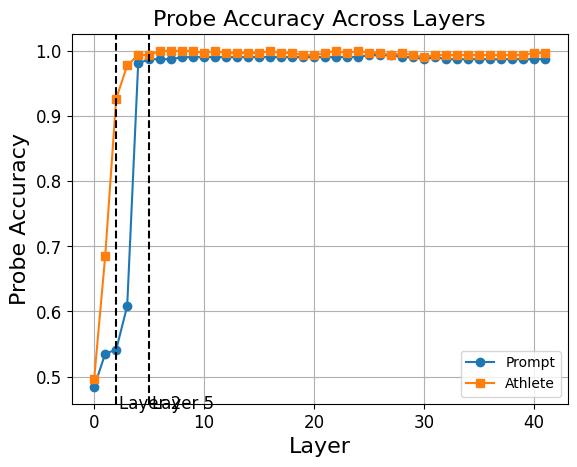

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
markers = ['o', 's', '^', 'v', '*', 'p', 'P', 'X', 'd']
for i, (k, v) in enumerate(results.items()):
    plt.plot(v, label=k, marker=markers[i])

# Add vertical dotted lines at x = 2, x = 7
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=5, color='k', linestyle='--')
# Label these vertical lines
plt.text(2.3, 0.45, 'Layer 2', fontsize=12)
plt.text(5.3, 0.45, 'Layer 5', fontsize=12)

plt.legend()
plt.xlabel('Layer', fontsize=16)
plt.ylabel('Probe Accuracy', fontsize=16)
plt.title('Probe Accuracy Across Layers', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

### Ablate layer heads

In [ ]:
# Add mean ablate hooks
ablate_first_layer = 5

def mean_ablate_hook(act, hook, mean_cache):
    if hook.layer() >= ablate_first_layer:
        print(f'Hooked {hook.name}')
        act = mean_cache[hook.name]
    return act

model.add_hook(
    lambda name: 'attn_out' in name,
    functools.partial(mean_ablate_hook, mean_cache=mean_cache),
    "fwd"
)
results[f'Prompt + Ablate Heads at Layers >= {ablate_first_layer}'] = probe_across_layers(model, full_prompt_toks, df['sport'].tolist(), batch_size=128)

# Add mean ablate hooks
model.add_hook(
    lambda name: 'attn_out' in name,
    functools.partial(mean_ablate_hook, mean_cache=mean_cache),
    "fwd"
)
results[f'Athlete + Ablate Heads at Layers >= {ablate_first_layer}'] = probe_across_layers(model, athl_prompt_toks, df['sport'].tolist(), batch_size=128)
model.reset_hooks()

torch.Size([1566, 24])
Hooked blocks.5.hook_attn_out
Hooked blocks.6.hook_attn_out
Hooked blocks.7.hook_attn_out
Hooked blocks.8.hook_attn_out
Hooked blocks.9.hook_attn_out
Hooked blocks.10.hook_attn_out
Hooked blocks.11.hook_attn_out
Hooked blocks.12.hook_attn_out
Hooked blocks.13.hook_attn_out
Hooked blocks.14.hook_attn_out
Hooked blocks.15.hook_attn_out
Hooked blocks.16.hook_attn_out
Hooked blocks.17.hook_attn_out
Hooked blocks.18.hook_attn_out
Hooked blocks.19.hook_attn_out
Hooked blocks.20.hook_attn_out
Hooked blocks.21.hook_attn_out
Hooked blocks.22.hook_attn_out
Hooked blocks.23.hook_attn_out
Hooked blocks.24.hook_attn_out
Hooked blocks.25.hook_attn_out
Hooked blocks.26.hook_attn_out
Hooked blocks.27.hook_attn_out
Hooked blocks.28.hook_attn_out
Hooked blocks.29.hook_attn_out
Hooked blocks.30.hook_attn_out
Hooked blocks.31.hook_attn_out
Hooked blocks.32.hook_attn_out
Hooked blocks.33.hook_attn_out
Hooked blocks.34.hook_attn_out
Hooked blocks.35.hook_attn_out
Hooked blocks.36.hook

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Time taken: 54.711870431900024 seconds
finished multiprocessing
[0.4840764331210191, 0.535031847133758, 0.5414012738853503, 0.60828025477707, 0.9808917197452229, 0.9840764331210191, 0.9777070063694268, 0.9777070063694268, 0.9777070063694268, 0.9713375796178344, 0.964968152866242, 0.9490445859872612, 0.9426751592356688, 0.9299363057324841, 0.9267515923566879, 0.9331210191082803, 0.9140127388535032, 0.9076433121019108, 0.9044585987261147, 0.910828025477707, 0.8980891719745223, 0.8980891719745223, 0.8853503184713376, 0.8853503184713376, 0.8726114649681529, 0.8789808917197452, 0.8248407643312102, 0.7961783439490446, 0.8057324840764332, 0.7834394904458599, 0.7515923566878981, 0.732484076433121, 0.7133757961783439, 0.7070063694267515, 0.6815286624203821, 0.6847133757961783, 0.6719745222929936, 0.6751592356687898, 0.6719745222929936, 0.6656050955414012, 0.6687898089171974, 0.6719745222929936]
{0: 0.4840764331210191, 1: 0.535031847133758, 2: 0.5414012738853503, 3: 0.60828025477707, 4: 0.980891

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Time taken: 54.88229584693909 seconds
finished multiprocessing
[0.4968152866242038, 0.6847133757961783, 0.9267515923566879, 0.9777070063694268, 0.9936305732484076, 0.9936305732484076, 0.9904458598726115, 0.9872611464968153, 0.9936305732484076, 0.9872611464968153, 0.9904458598726115, 0.9904458598726115, 0.9840764331210191, 0.9904458598726115, 0.9904458598726115, 0.9904458598726115, 0.9904458598726115, 0.9936305732484076, 0.9936305732484076, 0.9936305732484076, 0.9904458598726115, 0.9872611464968153, 0.9840764331210191, 0.9840764331210191, 0.9808917197452229, 0.9777070063694268, 0.9777070063694268, 0.9777070063694268, 0.9585987261146497, 0.9554140127388535, 0.9363057324840764, 0.9394904458598726, 0.9299363057324841, 0.9267515923566879, 0.9299363057324841, 0.9299363057324841, 0.9299363057324841, 0.9235668789808917, 0.9203821656050956, 0.9203821656050956, 0.9203821656050956, 0.9140127388535032]
{0: 0.4968152866242038, 1: 0.6847133757961783, 2: 0.9267515923566879, 3: 0.9777070063694268, 4: 

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


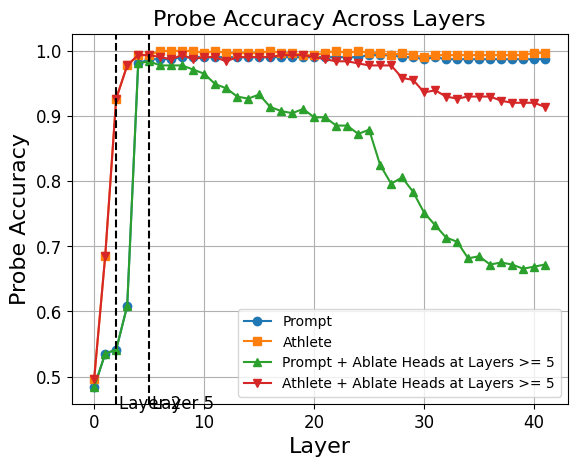

(50859081728, 85167243264)


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
markers = ['o', 's', '^', 'v', '*', 'p', 'P', 'X', 'd']
for i, (k, v) in enumerate(results.items()):
    plt.plot(v, label=k, marker=markers[i])

# Add vertical dotted lines at x = 2, x = 7
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=5, color='k', linestyle='--')
# Label these vertical lines
plt.text(2.3, 0.45, 'Layer 2', fontsize=12)
plt.text(5.3, 0.45, 'Layer 5', fontsize=12)

plt.legend()
plt.xlabel('Layer', fontsize=16)
plt.ylabel('Probe Accuracy', fontsize=16)
plt.title('Probe Accuracy Across Layers', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()
print(torch.cuda.mem_get_info())

## Early attention heads

In [8]:
full_prompt_toks = tokenize_instructions(tokenizer, df['prompt'].tolist()) # Full prompt
athl_prompt_toks = tokenize_instructions(tokenizer, df['athlete'].tolist()) # <bos>name
m_cache = get_mean_cache(model, hook_name="hook_z")
mean_cache = {}
for k in m_cache.keys():
    mean_cache[k] = einops.reduce(
        m_cache[k],
        'batch seq head d_model -> 1 1 head d_model',
        'mean'
    )
print(torch.cuda.mem_get_info())

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

(50863276032, 85167243264)


In [10]:
ablate_first_layer = 5
def act_patch_hook_z(act, hook, patch_cache, patch_layer, patch_head):
    # heads_to_patch is [(layer, head)]
    # heads = [head for layer, head in heads_to_patch if layer == hook.layer()]

    # act is batch head seq d_model

    # want to patch head and every head after layer ablate_first_layer
    if hook.layer() == patch_layer:
        act[:, :, patch_head, :] = patch_cache[hook.name][:, :, patch_head, :]
    elif hook.layer() >= ablate_first_layer:
        act = patch_cache[hook.name]

    return act


layer_range = range(0, ablate_first_layer)
head_range = range(0, model.cfg.n_heads)

heads_to_patch = [
    (layer, head)
    for layer in layer_range
    for head in head_range
]

# Get patch cache
# results_mat = torch.zeros((len(list(layer_range)), len(list(head_range))), device=device)
# for (layer, head) in tqdm(heads_to_patch):
#     # print(f'Patching L{layer}H{head}')

#     model.reset_hooks()

#     model.add_hook(
#         lambda name: 'hook_z' in name,
#         functools.partial(act_patch_hook_z, patch_cache=mean_cache, patch_layer=layer, patch_head=head),
#         "fwd"
#     )

#     results_mat[layer, head] += probe_last_layer(model, full_prompt_toks, df['sport'].tolist(), batch_size=64, layer=ablate_first_layer) 

#     model.reset_hooks()
# torch.save(results_mat, f'results/9b_patch_results_{ablate_first_layer=}.pt')

results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')

/tmp/ipykernel_2267936/1760785832.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')


In [11]:
# Get baseline accuracy
model.reset_hooks()
model.add_hook(
    lambda name: 'hook_z' in name,
    functools.partial(act_patch_hook_z, patch_cache=mean_cache, patch_layer=-1, patch_head=-1),
    "fwd"
)

baseline_acc = probe_last_layer(model, full_prompt_toks, df['sport'].tolist(), layer=ablate_first_layer, batch_size=64) 

model.reset_hooks()

last layer probe, cache shape:  torch.Size([1566, 3584])
(1566, 3584) 1566
Accuracy: 0.9808917197452229


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/tmp/ipykernel_2267936/2255518465.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')


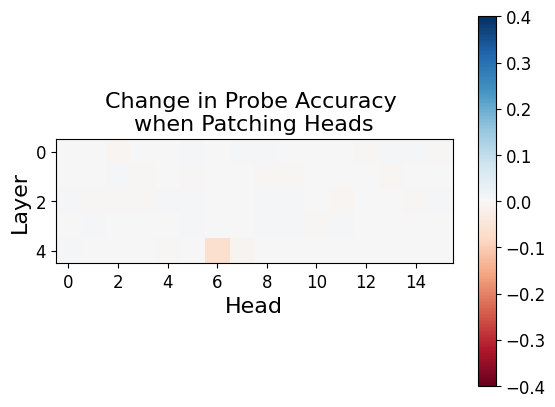

In [12]:
results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(results_mat.cpu().numpy() - baseline_acc, cmap='RdBu', vmax=.4, vmin=-.4)
plt.xlabel('Head', fontsize=16)
plt.ylabel('Layer', fontsize=16)
plt.title('Change in Probe Accuracy \nwhen Patching Heads', fontsize=16)
# increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# increase font size of colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.show()
fig.savefig(f'results/9b_patch_heatmap_{ablate_first_layer=}.pdf')

/tmp/ipykernel_2267936/4258570237.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')


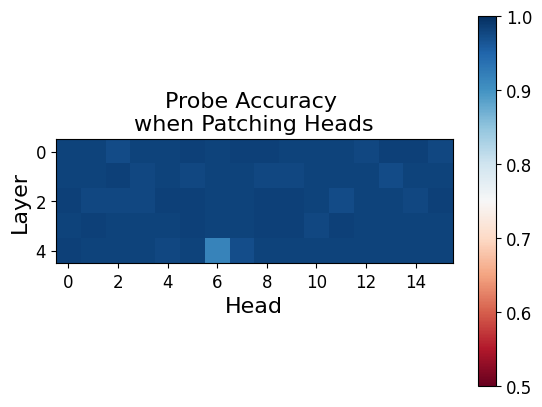

In [16]:
results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(results_mat.cpu().numpy(), cmap='RdBu', vmax=1, vmin=0.5)
plt.xlabel('Head', fontsize=16)
plt.ylabel('Layer', fontsize=16)
plt.title('Probe Accuracy \nwhen Patching Heads', fontsize=16)
# increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# increase font size of colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.show()
# fig.savefig(f'results/9b_patch_heatmap_{ablate_first_layer=}.pdf')